# Make figure for multiple resolutions of zeta in MPAS-O and ROMS

In [ ]:
import xarray as xr
import xroms
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import os
import cmocean.cm as cmo
import numpy as np
from numba_celltree import CellTree2d, demo
import time

from glob import glob
import graphviz

import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
from dask.distributed import Client

client = Client()
client

In [4]:
# Run local script to load functions that can calculate vorticity in ROMS outputs

run bichan_utils.py

## Load in MPAS-O model outputs

In [5]:
mroots = [
         '/mpaso_channel/10km/',
         '/mpaso_channel/5km/',
         '/mpaso_channel/2km/',
         '/mpaso_channel/1km/',
         '/mpaso_channel/500m/',    
         '/mpaso_channel/200m/',
         '/mpaso_channel/100m/'
]

In [6]:
mds = []
mdsg = []
mverts = []
midx = []
mnorm = []
for rootdir in mroots:
    ds_mpas = xr.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})
    dsg = xr.open_dataset(rootdir + 'channel_init.nc')
    ds_mpas['normalizedRelativeVorticity'] = ds_mpas.relativeVorticityCell / dsg.fCell
    ds_mpas['normalizedDivergence'] = ds_mpas.divergence / dsg.fCell
    mds.append(ds_mpas)
    mdsg.append(dsg)

    verts = np.dstack((dsg.xVertex.values[dsg.verticesOnCell-1],
                       dsg.yVertex.values[dsg.verticesOnCell-1]))
    nverts = np.sum(dsg.verticesOnCell != 0, axis=1).values
    verts = [vert[:n] for vert, n in zip(verts, nverts)]
    idx = [(np.abs(vert[:, 0].ptp()) < 50000) for vert in verts]
    midx.append(idx)
    verts = np.array(verts)[idx]
    mverts.append(verts)

    norm = plt.matplotlib.colors.Normalize(-3, 3)
    mnorm.append(norm)

## Load in ROMS model outputs

In [ ]:
rfiles = [
         '/roms_channel/10km/roms_his.nc',
         '/roms_channel/5km/roms_his.nc',
         '/roms_channel/2km/roms_his.nc',
         '/roms_channel/1km/roms_his.nc',
         '/roms_channel/500m/roms_his.nc',
         '/roms_channel/200m/roms_his.nc',
         '/roms_channel/100m/roms_his.nc',
        ]


In [9]:
rdss = []

for file in rfiles:
    if 'zarr' not in file:
        ds = xr.open_dataset(file, chunks={'ocean_time': 1})
    else:
        ds = xr.open_zarr(file, chunks={'ocean_time': 1})

    ds, xgrid = xroms.roms_dataset(ds)
    ds = add_derivatives(ds, xgrid) # This calls function that adds vorticity to datasets
    ds = ds.isel(s_rho=-1)
    rdss.append(ds)

#### Example plot comparing the 1 km resolution simulations for ROMS and MPAS-O

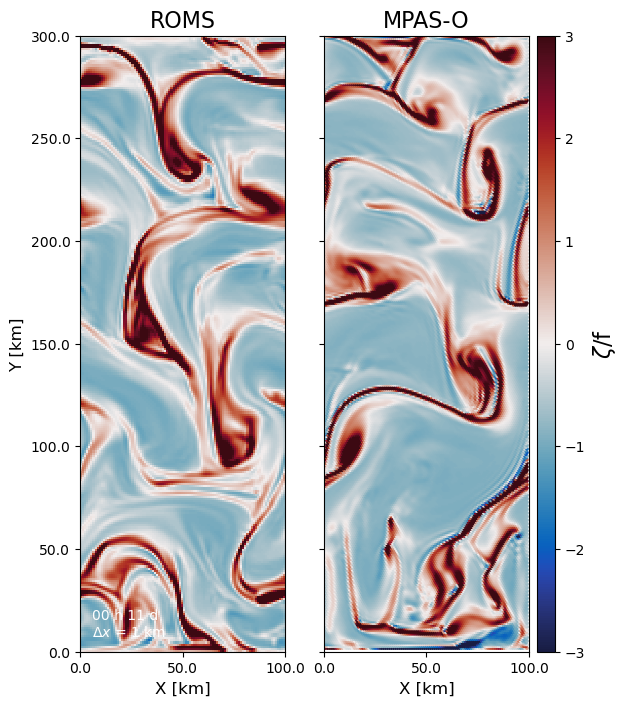

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(6, 8))
plt.subplots_adjust(hspace=0.12, wspace=0.1)

ds_roms = rdss[3]

ax_roms = axs[0]
surf_vel = ds_roms.zeta.isel(ocean_time=120, eta_rho=slice(1, -1), xi_rho=slice(1, -1))
pc = surf_vel.plot(x='x_rho', y='y_rho', 
                   ax=ax_roms, cmap=cmo.balance, add_colorbar=False)

pc.set_clim(-3, 3)
ax_roms.set_aspect(1.0)
ax_roms.set_xticks(np.arange(0, 500000, 50000))
ax_roms.set_yticks(np.arange(0, 500000, 50000))
ax_roms.set_xlim(0, 100000)
ax_roms.set_ylim(0, 300000)
ax_roms.set_xticklabels([str(x/1000.0) for x in ax_roms.get_xticks()])
ax_roms.set_yticklabels([str(y/1000.0) for y in ax_roms.get_yticks()])
ax_roms.set_ylabel('')
ax_roms.set_title('ROMS', fontsize=16)
ax_roms.set_xlabel('X [km]', fontsize=12)
ax_roms.set_ylabel('Y [km]', fontsize=12)

tstring = str(ds_roms.ocean_time[120].values)
day = tstring[8:10]
hour = tstring[11:13]
ax_roms.text(0.06, 0.02, 
        '{hour} h {day} d\n$\\Delta x$ = 1 km'.format(day=day, hour=hour) ,
        horizontalalignment='left',
        verticalalignment='bottom', color='w',
        transform=ax_roms.transAxes)

axi = 3
ax_mpas = axs[1]
norm = mnorm[axi]
verts = mverts[axi]
facecolors = cmo.balance(norm(mds[axi].normalizedRelativeVorticity.isel(nVertLevels=0, Time=120).values))
facecolors = facecolors[midx[axi]]

polys = plt.matplotlib.collections.PolyCollection(verts,
                                                      facecolors=facecolors, 
                                                      edgecolors=facecolors,
                                                     )
ax_mpas.add_collection(polys)
ax_mpas.set_xticks(np.arange(0, 500000, 50000))
ax_mpas.set_yticks(np.arange(0, 500000, 50000))
ax_mpas.set_xlim(0, 100000)
ax_mpas.set_ylim(0, 300000)
ax_mpas.set_aspect(1.0)
ax_mpas.set_xticklabels([str(x/1000.0) for x in ax_mpas.get_xticks()])
if axi==0:
    ax_mpas.set_yticklabels([str(y/1000.0) for y in ax_mpas.get_yticks()])
    ax_mpas.set_ylabel('Y [km]', fontsize=12)
else:
    ax_mpas.set_yticklabels('')
    ax_mpas.set_ylabel('')

ax_mpas.set_xlabel('X [km]', fontsize=12)
ax_mpas.set_title('MPAS-O', fontsize=16)


cax = fig.add_axes([0.9, 0.11, 0.03, 0.77])

cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('$\zeta$/f', fontsize=16)


## Combined plots

In [12]:
# Row and Column order for subplots
xvec = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
yvec = [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]

# Resolution string array for subplot titles
res_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']

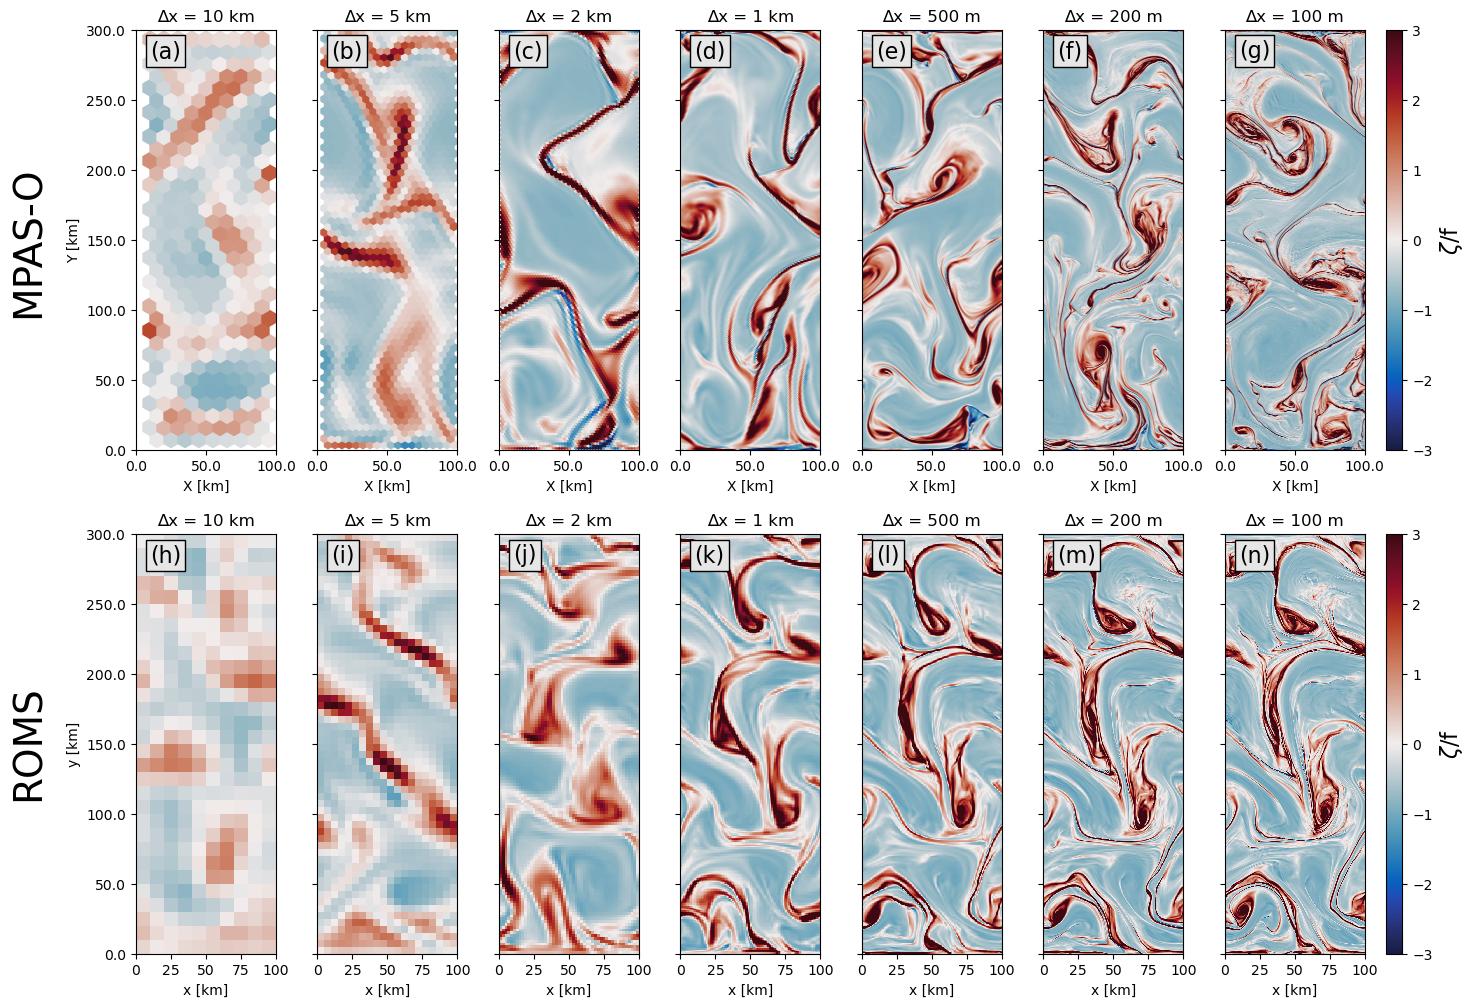

In [14]:
fig, axs = plt.subplots(2, 7, figsize=(16, 12))

# MPAS-O and ROMS kilometer resolution values
kl = [10, 5, 2, 1, 0.5, 0.2, 0.1, 10, 5, 2, 1, 0.5, 0.2, 0.1]

# MPAS resolutions in meters for slight alignment of model outputs within panels
m_dxs = [10E3, 5E3, 2E3, 1E3, 5E2, 2E2, 1E2]

plabel = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', '(n)']

raxi = 0 # Index for plotting ROMS outputs in same column as MPAS-O outputs
mtidx = 156 # MPAS time index to plot model outputs for all resolutions
rtidx = 120 # ROMS time index to plot model outputs for all resolutions

for axi in range(len(kl)):
    ax = axs[xvec[axi], yvec[axi]]
    
    if xvec[axi]==0: # MPAS plots
        norm = mnorm[axi]
        verts = mverts[axi]
        nuverts = verts.copy()
        nuverts[:,:,0] = nuverts[:,:,0] + m_dxs[axi]/2 # Slightly shift cell centers to align within figure better
        nuverts[:,:,1] = nuverts[:,:,1] - m_dxs[axi]   # Slightly shift cell centers to align within figure better
        facecolors = cmo.balance(norm(mds[axi].normalizedRelativeVorticity.isel(nVertLevels=0, Time=mtidx).values))
        facecolors = facecolors[midx[axi]]

        polys = plt.matplotlib.collections.PolyCollection(nuverts,
                                                          facecolors=facecolors, 
                                                          edgecolors=facecolors,
                                                         )
        ax.add_collection(polys)
        ax.set_xticks(np.arange(0, 500000, 50000))
        ax.set_yticks(np.arange(0, 500000, 50000))
        ax.set_xlim(0, 100000)
        ax.set_ylim(0, 300000)
        ax.set_aspect(1.0)
        ax.set_xticklabels([str(x/1000.0) for x in ax.get_xticks()])
        if axi==0:
            ax.set_yticklabels([str(y/1000.0) for y in ax.get_yticks()])
            ax.set_ylabel('Y [km]')
            ax.text(-90000.0, 100000.0, 'MPAS-O', size=28, rotation=90)            
        else:
            ax.set_yticklabels('')
            ax.set_ylabel('')

        ax.set_xlabel('X [km]')
        ax.set_title('∆x = %s' % res_lgd[axi], size=12)
        ax.text(10000.0, 280000.0,
                plabel[axi], bbox=dict(facecolor='0.9', edgecolor='k', pad=3.0), size=16)
        
    elif xvec[axi]==1: # ROMS plots        
        ds = rdss[raxi]
        pc = ds.zeta.isel(ocean_time=rtidx, xi_rho=slice(1, -1),
                          eta_rho=slice(1, -1)).plot(x='x_rho', y='y_rho',
                                           ax=ax, cmap=cmo.balance, add_colorbar=False)

        pc.set_clim(-3, 3)
        ax.set_aspect(1.0)
        ax.set_xlabel('x [km]')
        ax.set_xticklabels([str(x/1000.0) for x in ax.get_xticks()])
        if raxi==0:
            ax.set_ylabel('y [km]')
            ax.set_yticklabels([str(y/1000.0) for y in ax.get_yticks()])
            ax.text(-90000.0, 115000.0, 'ROMS', size=28, rotation=90)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')

        ax.set_title('∆x = %s' % res_lgd[raxi], size=12)
        ax.xaxis.set_ticks(np.arange(0, 110000, 25000))
        ax.xaxis.set_ticklabels(np.arange(0, 125, 25))
        ax.text(10000.0, 280000.0,
                plabel[axi], bbox=dict(facecolor='0.9', edgecolor='k', pad=3.0), size=16)        
        raxi+=1

        
# Add colorbar labels
cax1 = fig.add_axes([0.91, 0.53, 0.01, 0.35])
cbar = plt.colorbar(pc, cax=cax1, aspect=0.2)
cbar.ax.set_ylabel('$\zeta$/f', fontsize=16)

cax2 = fig.add_axes([0.91, 0.11, 0.01, 0.35])
cbar = plt.colorbar(pc, cax=cax2, aspect=0.2)
cbar.ax.set_ylabel('$\zeta$/f', fontsize=16)

plt.show()

